<a href="https://colab.research.google.com/github/Fed29/tutorials2021/blob/main/2_nlp/NLP_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Tutorial

Welcome to the second lab session of the [Mediterranean Machine Learning  summer school](https://www.m2lschool.org/home)!


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m2lschool/tutorials2021/blob/main/2_nlp/NLP_tutorial.ipynb)


In this tutorial, you will learn the fundamental components and main tasks in the Natural Language Processing (NLP) domain.

The tutorial is structured as follows:

* Imports and downloads (shared across sections)
* Part I: *Inner mechanisms of a vanilla Recurrent Neural Network (RNN)*
* Part II: *Character-level language modeling with Long-Short Term Memory (LSTM) networks*
* Part III: *Non-negative Matrix Factorization for topic modeling*
* Part IV: *From traditional (bag-of-words) to pretrained representations (BERT) for text classification*


All sections can be executed independently after running the initial import and download cells.

The sections marked as \[EXERCISE\] contain cells with missing code that you should complete.


Credits:
**[Federico Bianchi](https://federicobianchi.io)**, **[Debora Nozza](https://dnozza.github.io/)** and **[Francesco Visin](https://scholar.google.it/citations?user=kaAnZw0AAAAJ)**

### All Imports and Downloads

Here we are going to install and import everything we are going to need for this tutorial. 

**Note**: *You can double-click the title of the collapsed cells (as the ones below) to expand them and read their content.*

In [3]:
# @title Downloads and libraries installation
%%capture
!pip install git+https://github.com/deepmind/dm-haiku
!pip install optax
!pip install tensorflow-datasets
!pip install emoji
!pip install sentence-transformers

In [4]:
# @title Imports
import emoji
from functools import partial
import re
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

import haiku as hk
import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal, glorot_uniform, zeros
from jax import grad, jit, vmap, value_and_grad
from jax import random
from typing import Iterator, Mapping
from jax import lax
from jax.scipy.special import logsumexp
from jax import ops
import optax
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

from nltk.tokenize import RegexpTokenizer

# Part I. Vanilla RNN

**Goal**: Train a vanilla RNN to predict the next value of a temporal series given its previous values.

Specifically, we aim to predict

$$ 
sin (x +t \epsilon) 
$$ 

from

$$ 
sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) 
$$

In particular, we want the network to generate multiple predictions conditioned only on a few initial values. To do so, we will predict the next value of the function in a loop, conditioning on the value at the previous time-step (be it the initial, given, values or the ones predicted by the network at each previous step).

To learn the prediction model, we will use **teacher forcing**. This means that *during training* we will condition the model on values *coming from the ground truth* (i.e., the real sequence), rather than the output produced by the model at $t-1$. This makes training easier, because errors do not compound (a bad prediction at time $t$ does not influence the next prediction at time $t+1$).

At *inference time* (i.e., when we want to generate data from the model) we do not have access to the true sequence, so we must condition on the values *predicted by the model in previous time-steps*. This often leads to some compounding error, which generally makes it harder and harder to generate long sequences accurately.

To alleviate this problem we will also experiment with **warm starting**, which amounts to feeding the model with values coming from the ground truth (as done when teacher forcing) *only for a few initial steps*, and then feed it with its previous predictions instead. The rationale for this is to make training easier initially, to help the model learn the true function, and then feed it with its predictions to become robust to imperfect data.

## Training data

Let's store the sine wave over the interval $[0, 2\pi]$ as our training data. This will be our **ground truth**.

Note that differently from what is usually done, we don't have two separate training and test datasets here. Instead, we will train on random subsamples of the curve and then verify the ability of the network to generate the full curve when conditioned on a few initial values:

* Predict a few future values from a random starting point $x_s$;
* Generate the full trajectory, conditioned on a few initial points.

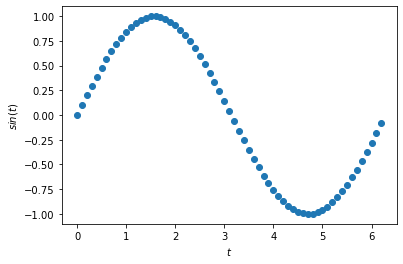

In [5]:
t = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1)
sin_t = np.sin(t)

plt.scatter(t, sin_t)
plt.xlabel('$t$')
plt.ylabel('$sin(t)$')
plt.show()

In [6]:
# @title Hyperparameters
WARM_START = 10                   #@param {type:'integer'}
TEACHER_FORCING = False           #@param {type:'boolean'}
STEP_SIZE = 0.0001                #@param {type:'number'}
UNROLL_LENGTH = 30                #@param {type:'integer'}
HIDDEN_DIMENSION = 20             #@param {type:'integer'}
NUM_ITERATIONS = 10000            #@param {type:'integer'}
REPORTING_INTERVAL = 500         #@param {type:'integer'}



As you have seen in the introductory lab, to use pseudo-random functions in JAX we need to instantiate a random number generator, and pass it explicitely to all the operations that work with random numbers (e.g. model initialization, dropout, etc, ...).

In [7]:
rnd_key = random.PRNGKey(1)

## RNN cell \[EXERCISE\]

Implement a basic RNN cell using *jax.numpy (jnp)* functions

$$ h_t = f( Wx_t + Vh_{t-1}  + b) $$
        
Where,

* $x_t$ input at time $t$,
* $h_t$ hidden state at time $t$,
* $W$ input-to-hidden mapping (trainable),
* $V$ hidden-to-hidden mapping (trainable),
* $b$ bias (trainable),
* $f$ non-linearity chosen (we use *tanh*)

Start by implementing a function to return the initial parameters:

In [41]:
def initialize_parameters(rnd_key):
    """
    Initialize and return the Vanilla RNN parameters.

    Args:
        rnd_key: random key

    Returns:
        A dict of weights with keys `V`, `W`, `bias`, `decoder`, `decoder_bias`.
    """

    input_dimension = 1   # the input is a scalar
    output_dimension = 1  # the output is a scalar

    ######################
    #   YOUR CODE HERE   #
    ######################
    # Initialize the Vanilla RNN parameters
    # using a glorot uniform distribution for W, 
    # V, decoder and zero values for bias and 
    # decoder_bias. Pay attention to the correct 
    # shapes of all parameters.

    keys = random.split(rnd_key, 5)
    params = {
        "V": glorot_uniform()(keys[0], (HIDDEN_DIMENSION, HIDDEN_DIMENSION)) ,
        "W": glorot_uniform()(keys[1], (input_dimension, HIDDEN_DIMENSION)),
        "bias": zeros(keys[2], (HIDDEN_DIMENSION,)),
        "decoder": glorot_uniform()(keys[3], (HIDDEN_DIMENSION, output_dimension)),
        "decoder_bias": zeros(keys[4], (output_dimension,)) 
    }

    assert params is not None, 'Params should be initialized'

    return params

In [42]:
glorot_uniform()(rnd_key, (1,20))

DeviceArray([[ 0.41028088, -0.33606613,  0.5251424 ,  0.0087587 ,
              -0.19477357,  0.2793812 ,  0.06686157, -0.24230464,
               0.01939154,  0.3333128 , -0.10369265, -0.26939535,
               0.22027242, -0.34620118, -0.21909308,  0.22857615,
               0.37328705,  0.38615915,  0.37770656,  0.3593984 ]],            dtype=float32)

In [43]:
UNROLL_LENGTH

30

In [44]:
gf = glorot_uniform()
gf(rnd_key, (5,5))

DeviceArray([[-0.16292979,  0.76340926,  0.5519019 ,  0.69512653,
               0.48012945],
             [ 0.08145696, -0.05145302, -0.58803475, -0.32430792,
              -0.5537915 ],
             [-0.11705147, -0.754989  , -0.50184596,  0.08242799,
              -0.07522812],
             [-0.54975647, -0.09334414,  0.22846305,  0.47966942,
               0.58099276],
             [ 0.61906326, -0.299846  , -0.34071973, -0.4103316 ,
              -0.65797937]], dtype=float32)

and then implement the RNN core itself:

In [120]:
def RNN_cell(params, x_t, current_state):
    """
    This function will be called in a loop, when RNN core is connected to
    inputs and previous states.

    Args:
        params: neural network paramters
        x_t: jax DeviceArray containing the current input `x_{t}`
        current_state: jax DeviceArray containing the previous state `h_{t-1}`

    Returns:
        A pair of RNN embedding and state.
    """

    ######################
    #   YOUR CODE HERE   #
    ######################
    # Compute the output of the RNN Cell by implementing the equation above.
    # h_t = f( W x_t + V h_{t-1}  + b )
    output = None
    f = jnp.tanh
    W = params.get("W")
    V = params.get("V")
    b = params.get("bias")

    # output = f(x_t * W + current_state * V + b)
    output = f(
        jnp.dot(x_t, W) + 
        jnp.dot(current_state, V) + 
        b
    )

    # ### Solution
    # input_to_hidden  = jnp.dot(x_t, params['W'])
    # hidden_to_hidden =  jnp.dot(current_state, params['V'])
    # activation = input_to_hidden + hidden_to_hidden + params['bias']
    # output = jnp.tanh(activation)
    assert output is not None, 'The RNN cell must compute the output'

    # The RNN cell returns pairs of (o_t, h_t), respectively the output and the 
    # state at time $t$. For vanilla RNN these are the same.
    return output, output

def get_initial_rnn_state(rnd_key):
    return zeros(rnd_key, (HIDDEN_DIMENSION,))

In [121]:
zeros(rnd_key, (HIDDEN_DIMENSION,))

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0.], dtype=float32)

In [122]:
params = {
    "V": glorot_uniform()(rnd_key, (1, 1)),
    "W": glorot_uniform()(rnd_key, (1, 1)),
    "bias": jnp.zeros(1),
    "decoder": glorot_uniform()(rnd_key, (1, 1)),
    "decoder_bias": jnp.zeros(1) 
}
output = None
f = jnp.tanh
W = params.get("W")
V = params.get("V")
b = params.get("bias")

In [123]:
x_t = sin_t[0]
W, x_t, W * x_t

(DeviceArray([[0.33769155]], dtype=float32),
 array([0.]),
 DeviceArray([[0.]], dtype=float32))

In [124]:
rnd_key, k1, k2 = random.split(rnd_key, 3)
current_state = get_initial_rnn_state(k2)
V, current_state, V * current_state

(DeviceArray([[0.33769155]], dtype=float32),
 DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0.], dtype=float32),
 DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0.]], dtype=float32))

In [125]:
x_t

array([0.])

In [126]:
output = f(W * x_t + V * current_state + b)

Now let's check that the output of the RNN is as expected.

In [127]:
HIDDEN_DIMENSION

20

In [128]:
rnd_key, k1, k2 = random.split(rnd_key, 3)
params = initialize_parameters(k1)
single_input = sin_t[0]
initial_state = get_initial_rnn_state(k2)

# RNN_cell returns two vectors, the output and the state. When the input is a 
# single element (i.e., not a sequence) each should have shape HIDDEN_DIMENSION.
assert len(RNN_cell(params, single_input, initial_state)[0]) == HIDDEN_DIMENSION
assert len(RNN_cell(params, single_input, initial_state)[1]) == HIDDEN_DIMENSION

## Next element prediction [EXERCISE]

The `predict` method defined below supports both *teacher forcing* and *warmup*. For educational purposes, we unrolled the RNN loop manually so it is easier to understand and debug the code. You need to implement the missing bits, applying the `RNN_cell` and returning a sequence of scalar predictions.

The `sin(x)` input sequence is composed of scalars, which is what the `RNN_cell` expects so you don't need to preprocess them. The predictions of the `RNN_cell` have shape `(HIDDEN_DIMENSION,),` so you need to apply the $\textbf{decoder}$ to recover the sequence of scalars we want to predict.

When you are done debugging, uncomment the **`@jit` decorator** to ensure the code is optimized and runs faster.

In [129]:
def encoder_decoder(params, encoded_input, current_state):
    # print(encoded_input.shape, current_state.shape)
    return jnp.dot(encoded_input, params['decoder']) + (
            params['decoder_bias'])

In [130]:
# @jit  # Uncomment for full speed!
@jax.partial(jax.jit, static_argnums=(3,))
def predict(params, initial_rnn_state, inputs, training=True):
    """Predict the next value of a sequence.

    Here we compute *one-step predictions*, i.e., we predict `sin_{t+1}` from 
    `sin_{t}`. Note however that depending on the values of the TEACHER_FORCING 
    and WARM_START parameters, sometimes we feed the model with the actual
    `sin_{t}` coming from the ground truth (i.e., `inputs`) and some other times
    with the last prediction of the model (which might or might not be 
    accurate). This means that in some cases not all the values of `inputs` will
    be used for training.

    This code a simplified implementation of `hk.static_unroll` for educational 
    purposes, do not use it in actual code. Statically unrolling the network has
    some caveats, e.g., it won't behave as expected if the length of the input
    sequence is variable. It is usually preferable to use `hk.dynamic_unroll`.

    Args:
        params: the parameters of the RNN
        initial_rnn_state: the initial state of the RNN
        inputs: the data passed in input to the RNN
        training: sets teacher forcing to True or False
    
    Returns:
        The next value predictions.
    """
    if training:
      teacher_forcing = TEACHER_FORCING
    else:
      teacher_forcing = False

    predictions = []
    current_state = initial_rnn_state

    # Unroll the rnn loop by hand.
    for t in range(len(inputs)):

        # When teacher forcing, the input is always the actual previous value 
        # (from the ground truth). Otherwise, we will feed the model with the 
        # actual previous values during the warm start period only, and then 
        # input the previous predictions instead.
        if teacher_forcing or t <= WARM_START:
            input_ = inputs[t]
        else:
            input_ = prediction

        ######################
        #   YOUR CODE HERE   #
        ######################
        # Connect the RNN: we apply our cell to (input, state) pairs, and we 
        # expect it to return (output, next_state) pairs; note how the current
        # state is updated with the next_state.
        rnn_embedding, next_state = None, None

        rnn_embedding, next_state = RNN_cell(params, input_, current_state)

        assert rnn_embedding is not None, 'The RNN must return an output'

        current_state = next_state

        ######################
        #   YOUR CODE HERE   #
        ######################
        # Create a linear mapping from RNN output to the target (scalar)
        # using the decoder and decoder bias parameters
        prediction = None

        prediction = encoder_decoder(params, rnn_embedding, current_state)

        assert prediction is not None, ('Connect the rnn embeddings and the '
                                        'decoder to get prediction')

        predictions.append(prediction)

    return jnp.stack(predictions)

### Shape check

Let's check that our RNN predictions returns the desired shape

In [131]:
# %%debug
# predictions = predict(params, initial_rnn_state, sin_t[:UNROLL_LENGTH], True)

In [132]:
# predictions.shape

In [133]:
rnd_key, k1, k2 = random.split(rnd_key, 3)
params = initialize_parameters(k1)
initial_rnn_state = get_initial_rnn_state(k2)
predictions = predict(params, initial_rnn_state, sin_t[:UNROLL_LENGTH], True)
assert len(predictions) == UNROLL_LENGTH

## Loss and weights update [EXERCISE]

We update the parameters of the network using the **ADAM** optimizer. In this section you need to complete the `loss_fn` that must compute the loss as the mean squared error of the prediction and the targets. As before, once you are done debugging uncomment the `@jit` decorator to ensure the code runs at full speed.

The `optimize` function uses this `loss_fn` function to compute the loss and the gradient of the loss w.r.t. the parameters of the network, and takes one step of gradient descent to reduce such loss. This is effectively one step of training.

In [134]:
@jit
def loss_fn(params, rnn_state, inputs, targets):
    """
    Loss function is a simple mean squared error. 

    Args:
        params: the parameters of the neural network
        rnn_state: the state of the rnn
        inputs: a sequence of inputs
        targets: a sequence of expected outputs

    Returns:
        The mean squared error.
    """

    ######################
    #   YOUR CODE HERE   #
    ######################
    # Obtain the prediction given the current state and input data
    # and compute the mean squared error with the targets.
    predictions = None
    mse = None

    predictions = predict(params, rnn_state, inputs, True)
    # predictions = predictions.numpy()

    mse = ((predictions - targets)**2).mean()

    assert predictions is not None, 'Get the RNN predictions'
    assert mse is not None, ('Compute the mean squared error between the '
                             'predictions and the target')
    assert predictions.shape == targets.shape, (
        f'The predictions should have the same shape as the input and target, '
        f'but are respectively {predictions.shape}, {inputs.shape}, '
        f'{targets.shape}')

    return mse

In [135]:
# loss_fn(params, initial_rnn_state, sin_t[:UNROLL_LENGTH], sin_t[1:UNROLL_LENGTH+1])

In [136]:
@jit
def optimize(params, opt_state, rnn_state, inputs, targets):
    """
    Updates the parameters and returns the loss values.

    Args:
        params: the parameters of the neural network
        opt_state: the state of the optimizer
        rnn_state: the state of the rnn
        inputs: a sequence of inputs
        targets: a sequence of expected outputs
    
    Returns:
        The loss, the new optimizer state and the updated network parameters.
    """
    loss_value, grads = jax.value_and_grad(loss_fn)(params, rnn_state, inputs,
                                                    targets)
    updates, opt_state = optimizer(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss_value, opt_state, params

## Training [EXERCISE]

In this section we will finally use all the functions defined above to train the network.

The following code prints an example of input and output data for an unroll length of 4. Note how the target at time $t$ is the input at time $t+1$. This is because we train the network to predict the next value in the sequence.

In [137]:
training_input = jnp.array(sin_t[:4])
training_target = jnp.array(sin_t[1:5])

print('Example of training sample')
print('input-> ', training_input.ravel())
print('target-> ', training_target.ravel())

Example of training sample
input->  [0.         0.09983341 0.19866933 0.29552022]
target->  [0.09983341 0.19866933 0.29552022 0.38941833]


At this point, all the functions and parameters have been defined. We can create the training loop, run it and visualize the output plot predictions

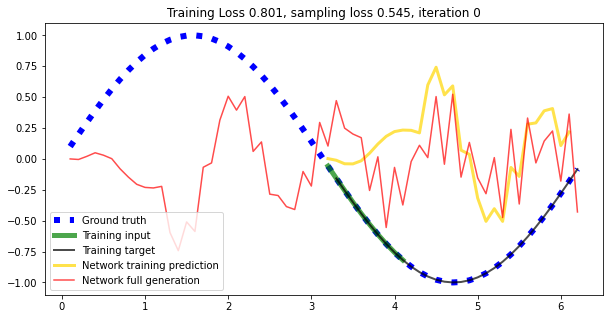

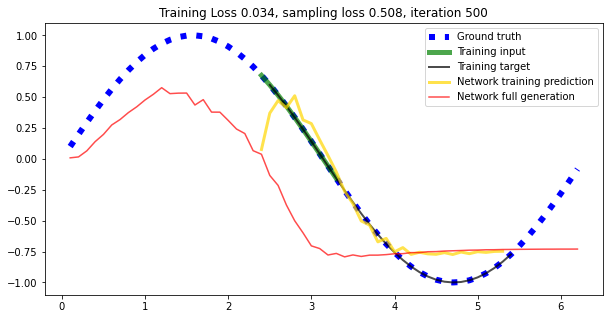

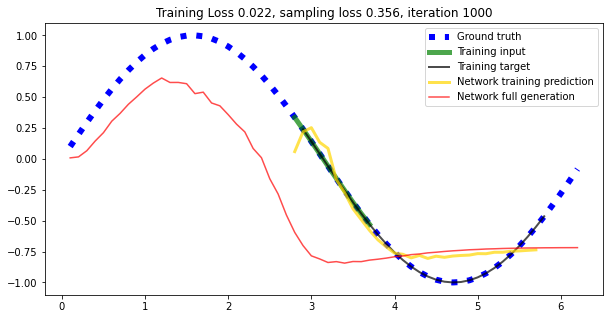

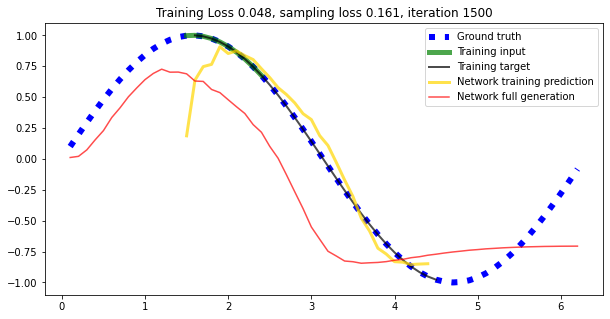

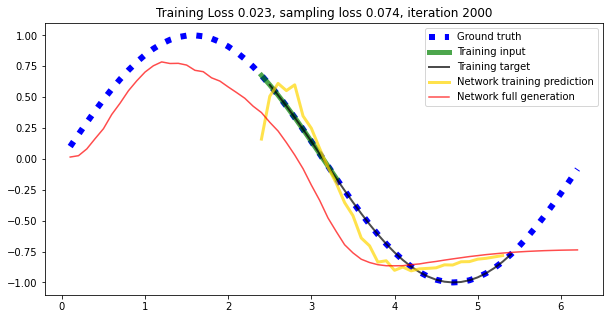

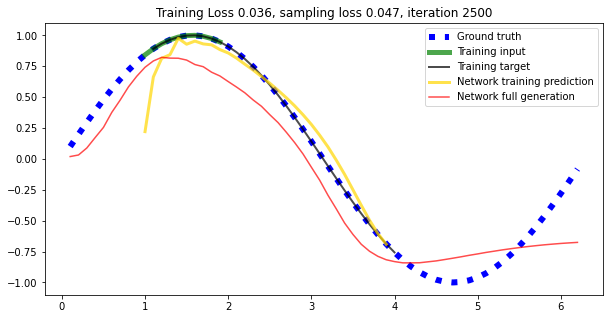

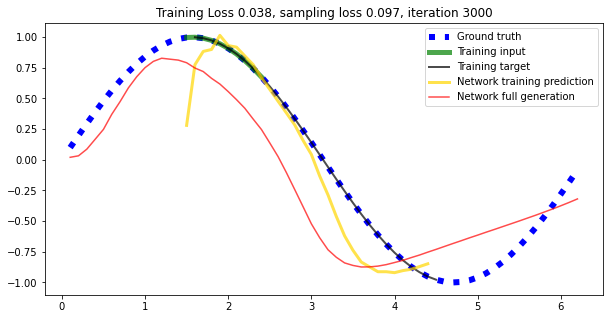

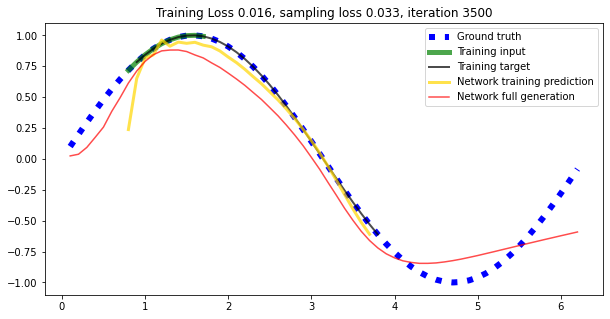

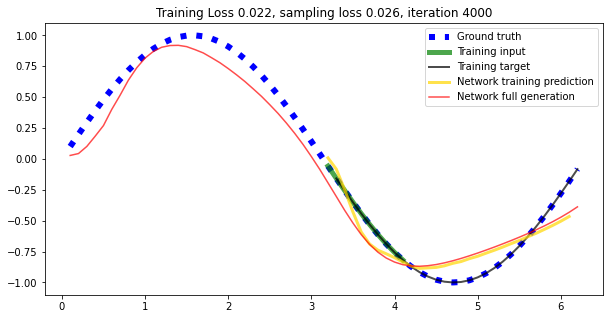

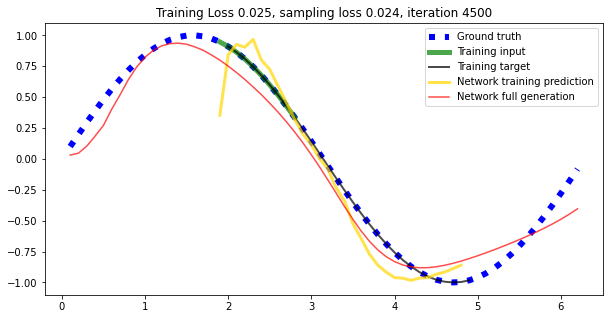

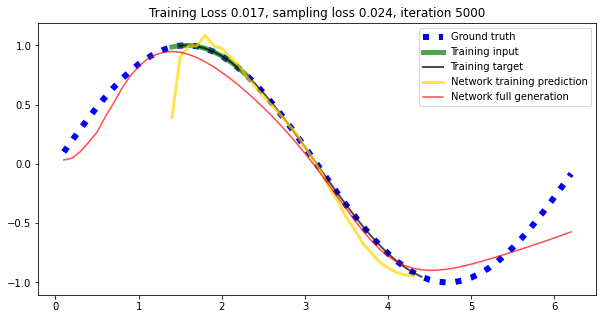

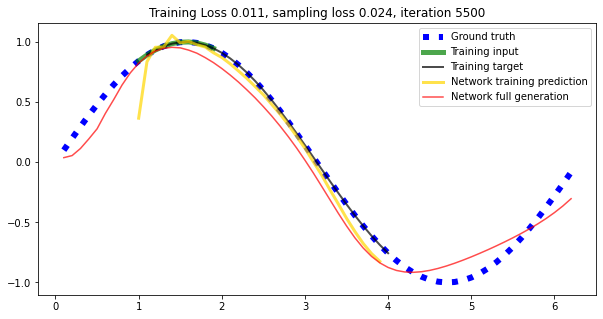

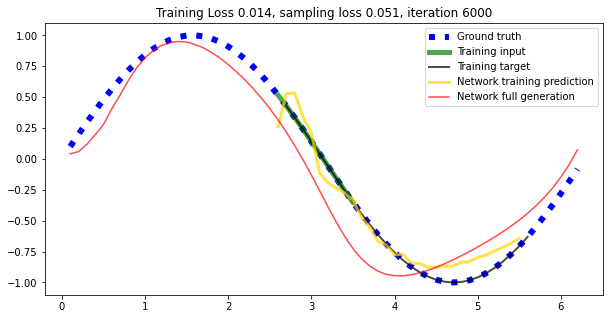

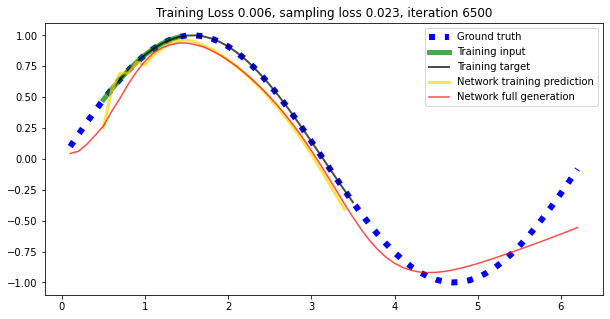

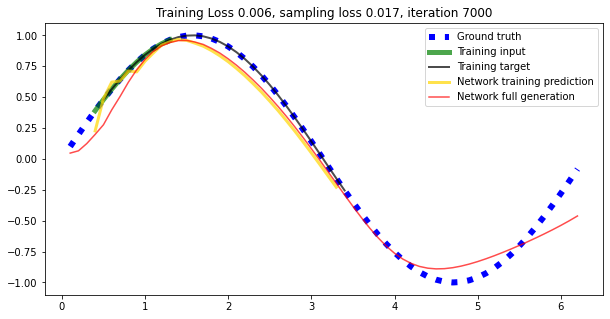

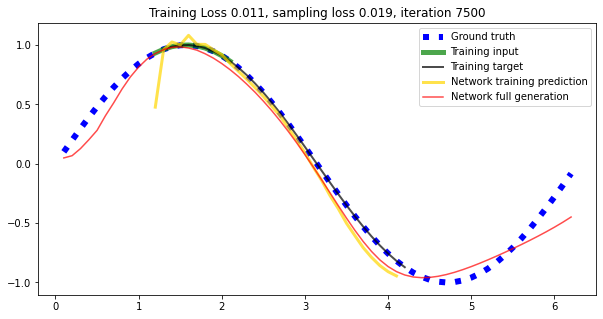

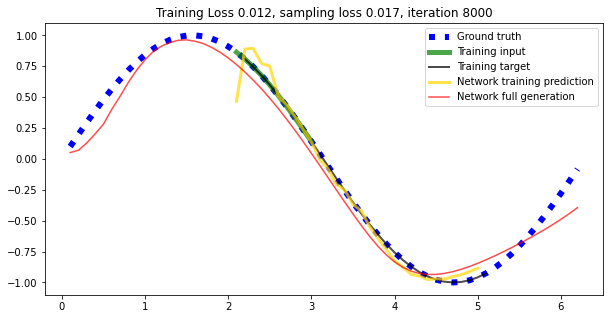

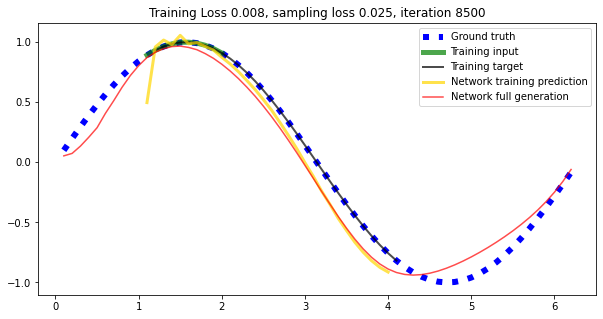

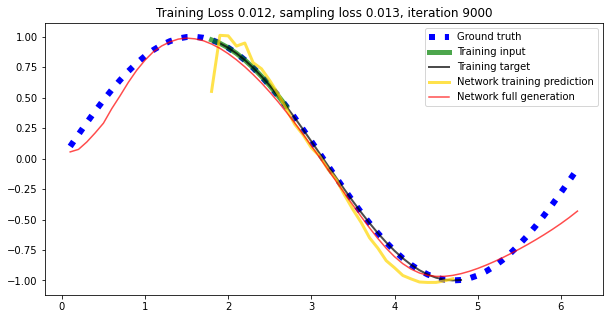

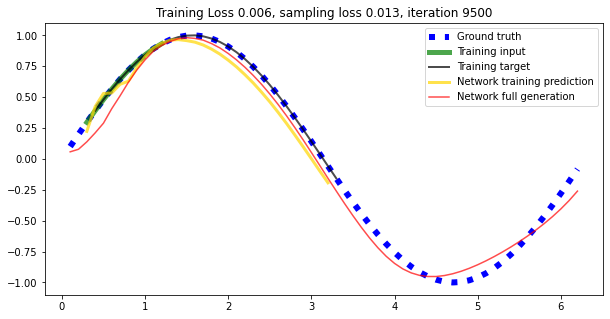

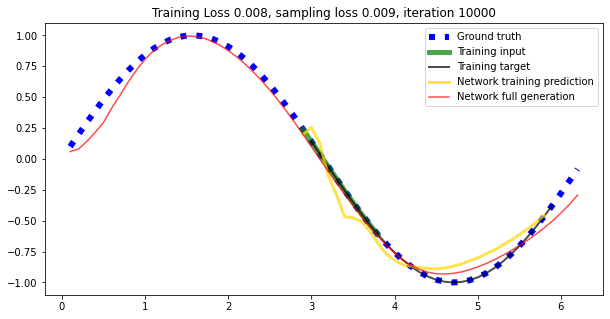

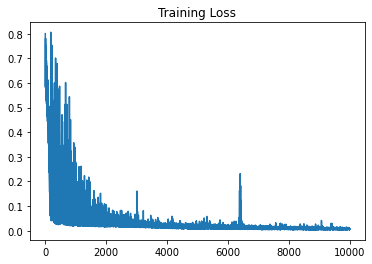

In [138]:
######################
#   YOUR CODE HERE   #
######################
# Initialize parameters and get the initial state of the RNN
params = None
initial_rnn_state = None

params = initialize_parameters(rnd_key)
initial_rnn_state = get_initial_rnn_state(rnd_key)

assert params is not None, 'Initialize params of the RNN.'
assert initial_rnn_state is not None, 'Get the initial state of the RNN.'


opt_init, optimizer = optax.adam(STEP_SIZE)
opt_state = opt_init(params)

losses = []
for i in range(NUM_ITERATIONS+1):
    # Training.
    start = np.random.choice(range(len(sin_t) - UNROLL_LENGTH))
    training_input = jnp.array(sin_t[start: start+UNROLL_LENGTH])
    training_target = jnp.array(sin_t[start+1: start+UNROLL_LENGTH+1])
    # Note: `optimize` calls prediction, computes the loss and updates the 
    # parameters of the network and the state of the optimizer.
    loss_value, opt_state, params = optimize(params, opt_state, 
                                             initial_rnn_state, training_input, 
                                             training_target)
    losses.append(loss_value.tolist())

    # Full sequence generation and plotting.
    if i % REPORTING_INTERVAL == 0:

        # Generate the full sequence (from the first to the last element).
        y_gen = predict(params, initial_rnn_state, sin_t[:-1], False)
        sampling_loss = loss_fn(params, initial_rnn_state, y_gen, sin_t[1:])
        plt.figure(figsize=(10, 5))

        plt.title(f'Training Loss {loss_value.tolist():.3f}, sampling loss '
                  f'{sampling_loss.tolist():.3f}, iteration {i}')

        plt.plot(t[1:].ravel(), sin_t[1:].ravel(), c='blue',
                 label='Ground truth',
                 linestyle=':', lw=6)

        if TEACHER_FORCING:
            plt.plot(t[start: start+UNROLL_LENGTH].ravel(),
                   training_input.ravel(),
                   alpha=0.7, lw=5, c='green', label='Training input')
        else:
            plt.plot(t[start: start+WARM_START].ravel(),
                   training_input[:WARM_START].ravel(),
                   alpha=0.7, lw=5, c='green', label='Training input')
        plt.plot(t[start+1: start+UNROLL_LENGTH+1].ravel(),
                 training_target.ravel(),
                 alpha=0.7, lw=2, c='black', label='Training target')

        plt.plot(t[start: start+UNROLL_LENGTH].ravel(),
                 predict(params, initial_rnn_state, training_input, True),
                 alpha=0.7, lw=3, c='gold', label='Network training prediction')

        plt.plot(t[1:].ravel(),
                 y_gen,
                 alpha=0.7, c='r', label='Network full generation')

        plt.legend()
        plt.show()

plt.figure()
plt.title('Training Loss')
_ = plt.plot(losses)

Now try changing the hyperparameters and see how they affect the training (e.g., how accurately does the network learn to model the curve, how fast does it converge, etc, ...)

## **What is worth trying/understanding here?**
- Difference between teacher forcing and learning on own samples:
 - What are the pros and cons of teacher forcing?
 - Why is the model struggling to learn in one of the setups?
 - What is it that we actually care about when we model sequences? How can this be negatively affected by teacher forcing?
- Effect of warm starting:
  - How does warm starting affect our training when teacher forcing is disabled? Why?
  - How does warm starting affect our sampling when teacher forcing is enabled? Why?
- What happens if the structure of interest is much longer than the unroll length?


# Part II: Character-level language modeling

**Goal**: Train a character level LSTM on text data - specifically Shakespeare's sonnets. 

**What is an LSTM**: An LSTM is an advanced variant of the RNN. As opposed to the vanilla RNN the output and the state are separate, which allows for much more flexibility in deciding what to store. The LSTM is also characterized by a more advanced mechanism to determine which parts of the input to store into the memory and what to potentially forget. *For an in-depth analysis of the differences between various kinds of RNNs, we recommend you to read [this excellent guide](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah.*

**Haiku**: In order to develop our network we will use [Haiku](https://github.com/deepmind/dm-haiku), which provides many common building blocks, including LSTMs! 

**This tutorial**: Throughout this section you will build the network, train an LSTM on a dataset of Shakespeare's sonnets and finally you will be able to see how the quality of the generated text improves over time as the network trains.

In [ ]:
# @title Hyper-parameters
BATCH_SIZE = 32           #@param {type:'integer'}
SEQUENCE_LENGTH = 128     #@param {type:'integer'}
HIDDEN_SIZE = 256         #@param {type:'integer'}
SAMPLE_LENGTH = 128       #@param {type:'integer'}
LEARNING_RATE = 1e-3      #@param {type:'number'}
TRAINING_STEPS = 6500   #@param {type:'integer'}
SAMPLING_INTERVAL = 200   #@param {type:'integer'}
SEED = 43                 #@param {type:'integer'}
NUM_CHARS = 128           #@param {type:'integer'}

In [ ]:
#@title Dataset loader with encoding and decoding functions { form-width: "170px" }
Batch = Mapping[str, np.ndarray]

def load(split: tfds.Split, *, batch_size: int,sequence_length: int):
    '''Creates the Tiny Shakespeare dataset as a character modelling task.'''

    def preprocess_fn(x: Mapping[str, tf.Tensor]) -> Mapping[str, tf.Tensor]:
        x = x['text']
        x = tf.strings.unicode_split(x, 'UTF-8')
        x = tf.squeeze(tf.io.decode_raw(x, tf.uint8), axis=-1)
        x = tf.cast(x, tf.int32)
        return {'input': x[:-1], 'target': x[1:]}

    ds = tfds.load(name='tiny_shakespeare', split=split)
    ds = ds.map(preprocess_fn)
    ds = ds.unbatch()
    ds = ds.batch(sequence_length, drop_remainder=True)
    ds = ds.shuffle(100)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.map(lambda b: tf.nest.map_structure(tf.transpose, b))  # Time major.
    return tfds.as_numpy(ds)

def decode(x: np.ndarray) -> str:
    return ''.join([chr(x) for x in x])

def encode(x: str) -> np.ndarray:
    return np.array([ord(s) for s in x])

## Build the network with Haiku [EXERCISE]

In this section you will need to use Haiku to build the network. To do so, you will make use of the `hk.DeepRNN` ([doc](https://dm-haiku.readthedocs.io/en/latest/api.html#haiku.DeepRNN)) module to wrap together several layers into a single RNN core.

Implement the following architecture:

- Convert the input to a one-hot representation with `NUM_CHARS` elements (hint: use a lambda function `lambda x: jax.nn.one_hot(...)`) [(doc)](https://github.com/google/jax/blob/6c8fc1b031275c85b02cb819c6caa5afa002fa1d/jax/_src/nn/functions.py#L261)
- LSTM of `HIDDEN_SIZE` size ([doc](https://dm-haiku.readthedocs.io/en/latest/api.html?highlight=lstm#lstm))
- ReLU (non-linearity) ([doc](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.relu.html))
- LSTM of `HIDDEN_SIZE` size ([doc](https://dm-haiku.readthedocs.io/en/latest/api.html?highlight=lstm#lstm))
- An two-layer MLP composed of a layer of `HIDDEN_SIZE` size with ReLU activation, followed by a linear (no activation) layer mapping to the final problem size (number of characters: `NUM_CHARS`) ([docstring](https://github.com/deepmind/dm-haiku/blob/300e6a40be31e35940f0725ae7ed3457b737a5a3/haiku/_src/nets/mlp.py#L38))

In [ ]:
def make_network() -> hk.RNNCore:
    """Define the RNN core."""
    ######################
    #   YOUR CODE HERE   #
    ######################
    # Design the LSTM with Haiku
    # following the architecture
    # defined in the text above.
    
    rnn_core = hk.DeepRNN([
        # add code
    ])

    assert rnn_core is not None, 'LSTM model should be initialized'

    return rnn_core

## Loss and Update [EXERCISE]
As before, we update the parameters of the network using the **ADAM** optimizer. 

In this section you need to complete the `loss_fn`, which should compute the loss as the categorical cross-entropy of the prediction and the targets. The `optimize` function (which you don't need to modify) uses this `loss_fn` function to compute the loss and the gradient of the loss w.r.t. the parameters of the network, and takes one step of gradient descent to reduce such loss. This is effectively one step of training.

As before, once you are done debugging uncomment the `@jit` decorator **to ensure the code runs at full speed**.

### Categorical Cross-entropy Recap
The categorial cross-entropy loss is computed as

$$\mathcal{L}_{\text{xent}} = - \mathbf{y} \cdot \log(\mathbf{\hat{y}})$$

where $\mathbf{y}$ is the true class probability and $\mathbf{\hat{y}}$ is the predicted class probability.

**Example**

Let's take as an example a classification problem with 3 classes. Assume our **target vector** for the current sample to be $[0, 1, 0]$ (i.e., the second class is the correct one, according to the ground truth). If our network's **predicted class probability** is $[0.2, 0.7, 0.1]$, the categorical cross-entropy loss for this prediction will be

$$
\begin{align}
  \mathcal{L}_{\text{xent}} =& - \bigg( 0 \cdot \log(0.2) + 1 \cdot \log(0.7) + 0 \cdot \log(0.1) \bigg)\\
  =& - \log(0.7) \\ 
  =& \; 0.35
\end{align}
$$

In this case, the network was fairly confident that the input belonged to the second class, which was correct, so the error is not very large.

Let's see what would have happened if the network was mistakenly confident that the true class was another one instead. Suppose the predicted vector was $[0.8, 0.05, 0.15]$, i.e., that the network was assigning a very low probability to the true class. The loss in this case would have been $-\log(0.05) = 3$, which is much higher than before.

In [ ]:
def loss_fn(batch):
    """
    Compute the categorical cross-entropy loss.

    Unroll the network over a sequence of batched inputs & targets, and
    compute the categorical cross-entropy loss.

    Args:
        logits: the logits from the network
        batch: a batch of input and target data

    Returns:
        The categorical cross-entropy loss.
    """
    sequence_length, batch_size = batch['input'].shape

    ######################
    #   YOUR CODE HERE   #
    ######################
    # create the network and unroll it (dynamic unrolling)
    # Obtain the prediction by computing the log_softmax on logits
    # Convert the log probabilities to one hot labels
    # and compute the categorical cross-entropy loss
    loss = None

    assert loss is not None, 'Loss should be computed'

    return loss


# @jit
def optimize(params, opt_state, batch):
    """
    Applies an update to the parameters.

    Args:
        params: the parameters of the neural network
        opt_state: the state of the optimizer
        batch:  batch of input and target data

    Returns:
        The new optimizer state and the updated network parameters.
    """
    ######################
    #   YOUR CODE HERE   #
    ######################
    # Similar to the RNN update function
    # - initialize the Adam optimizer
    # - apply grad function to loss
    # - compute params updates
    # - apply updates on params
    new_params = None
    new_opt_state = None

    # Note that since JAX is stateless (the state is passed explicitly to each 
    # operation) here we create another optimizer function for simplicity, 
    # instead of passing the one we create when we first initialize the state
    # of the optimizer.

    assert new_opt_state is not None, 'Compute the updated optimizer\'s state.'
    assert new_params is not None, 'Compute the updated parameters.'

    return new_params, new_opt_state

## Sampling function

This function draws samples from the model, given an initial context.

In [ ]:
def sample_fn(rng_key: jnp.ndarray, context: jnp.ndarray, sample_length: int):
    """
    Draws samples from the model, given an initial context.

    Note: this function is impure; we will hk.transform() it (and jit it) in the
    training loop.

    Args:
        rng_key: random key
        context: initial context given to the model
        sample_length: length of the sample

    Returns:
        the generated tokens
    """
    assert context.ndim == 1  # Sequence only, no batch

    def body_fn(t, values):
        tokens, state, rng_key = values
        token = tokens[t]
        next_logits, next_state = rnn_core(token, state)
        rng_key, k1 = jax.random.split(rng_key)
        next_token = jax.random.categorical(k1, next_logits, axis=-1)
        new_tokens = ops.index_update(tokens, ops.index[t + 1], next_token)
        return new_tokens, next_state, rng_key

    # Unroll over context (initial prompt).
    rnn_core =  make_network()
    initial_state = rnn_core.initial_state(None)  # no batch here!
    logits, state = hk.dynamic_unroll(rnn_core, context, initial_state)

    # Sample the first continuation token and initialize the output array.
    rng_key, k1 = jax.random.split(rng_key)
    first_token = jax.random.categorical(k1, logits[-1])
    tokens = np.zeros(sample_length, dtype=np.int32)
    tokens = ops.index_update(tokens, ops.index[0], first_token)

    # Sample the other tokens in a loop.
    initial_values = tokens, state, rng_key
    new_tokens, _, _ = lax.fori_loop(0, sample_length, body_fn, initial_values)

    return new_tokens

## Train and generate language
Finally, this training loop puts everything together. The network is trained for a fixed number of `TRAINING_STEPS` and is evaluated at fixed intervals. During the evaluation, given a *context* sentence provided as input, the network tries to generate some text to complete that prompt.

As you can see, for the first few iterations the model generates nonsensical sentences, but after some training you can observe that the model is actually learning to reproduce text that resembles Shakespeare's sonnets.

**Important:** make sure you uncommented the `@jit` decorators in the previous
code to enjoy accelerated training. Training should take less than 7 minutes.


In [ ]:
%%time
# Note that since we use Haiku, we use their PRNG instead of the one from JAX.
rng = hk.PRNGSequence(SEED)

train_data = load(tfds.Split.TRAIN, batch_size=BATCH_SIZE,
                  sequence_length=SEQUENCE_LENGTH)
train_data = iter(train_data)

# Out network doesn't have a nondifferentiable state (the inner states of the 
# LSTMs is differentiable), so we don't need to use `hk.transform_with_state` 
# and can use the typical `hk.transform` instead. Further, our network does not
# have stochastic operations, so we can wrap it in a `without_apply_rng` call.
# Note that here we transform `loss_fn` as a way to initialize the network
# parameters a few lines below.
transformed_loss = hk.without_apply_rng(hk.transform(loss_fn))
_, sample = hk.without_apply_rng(hk.transform(sample_fn))
sample = jax.jit(sample, static_argnums=[3])  # sample_length is static

# Setup optimizer.
params = transformed_loss.init(next(rng), next(train_data))
# Similar to what we do for the loss, here we create the optimizer just to get
# the initial optimizer state.
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(params)

BOLD = '\033[1m'
END =  '\033[0m'
SEP = '\n------------------------------\n'
for step in range(TRAINING_STEPS):
    train_batch = next(train_data)  # includes input and target
    
    # Run one step of training and update the parameters.
    params, opt_state = optimize(params, opt_state, train_batch)

    if step % SAMPLING_INTERVAL == 0:
        # Use the input text of the batch as context.
        context = train_batch['input'][:, 0]  # drop the batch
        rng_key = next(rng)
        # Sample generated text given context.
        samples = sample(params, rng_key, context, SAMPLE_LENGTH)
        # Decode context and samples to actual sentences.
        prompt = decode(context)
        continuation = decode(samples)

        print(f'{BOLD}>>> Prompt (from the dataset):{SEP}{END}\n{prompt}\n')
        print(f'{BOLD}Continuation (from the network):{END}\n{continuation}\n')

## **What is worth trying/understanding here?**
- After how many iterations the model is able to learn a sentence which makes sense?
- Why the first generated sentences do not make sense and what pattern can you see?
- How is the sample length parameters affecting the results?

Answers:

- same words repeated

# Part III: Topic modeling with Non-negative Matrix Factorization

**Goal**: Extract topics from a set of documents exploiting *matrix factorization*.

**What is topic modeling**: *Topic modeling* is a Natural Language Processing task whose aim is to discover the abstract *topics* that occur in a set of documents. Intuitively the idea is that, depending on the topic discussed in a document or a set of documents, specific words will appear more or less frequently. For instance, 'dog' and 'bone' will appear more often in documents about dogs, while 'cat' and 'meow' will appear in documents about cats. Common words, like 'the' and 'is', will tend to appear approximately uniformely in all kinds of documents so are not very informative to tell the documents apart. We can exploit this to cluster the documents in groups, according to their topic.

**Credits:** this code is an adaptation of [this fast.ai tutorial](https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/2.%20Topic%20Modeling%20with%20NMF%20and%20SVD.ipynb).

## Load dataset

In this section, we will use the well-known benchmark dataset **20newsgroups** to model the main topics discussed in a group of conversations. Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts on 20 different topics.

In [ ]:
categories = ['rec.motorcycles', 'sci.med', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)

In [ ]:
# Print three random documents.
print('\n\n-----\n'.join(newsgroups_train.data[:3]))

In [ ]:
# Print the category of the previous documents.
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

## Document discrete representations

In order to represent the documents as a **term-document matrix**, we need to transform unstructured data (text) to structured data.

This can be performed by extracting count and/or frequencies of words in each documents.

- The **Bag of Words (BoW)** model is the simplest way to represent text in numerical form. As the name suggests (nomen omen!), given a vocabulary of words we can represent any sentence as a *bag of words vector* (i.e., a vector of numbers) using the *counts*, i.e. we count how many times each word in the dictionary appears in the documents.

- The **TF-IDF** (Term Frequency - Inverse Document Frequency) representation model is similar, but accounts for both the frequencies of words and their importance. For example, if a words appears in all the documents, it is not very important, as it does not allow us to differentiate documents.

We will use **TF-IDF** representations, which we will extract using the [sklearn](https://scikit-learn.org/) library. 


In [ ]:
# Initialize the TF-IDF representation model.
tf_idf = TfidfVectorizer(stop_words='english', min_df=10)
# Apply TF-IDF representation to the documents.
X_train = tf_idf.fit_transform(newsgroups_train['data'])
X_train = X_train.todense()
X_train = jnp.array(X_train)

In [ ]:
X_train.shape

In [ ]:
# Each column of the representation matrix corresponds to a word.
vocab = np.array(tf_idf.get_feature_names())
print(vocab)

## Non-Negative Matrix Factorization [EXERCISE]

**Non-Negative Matrix Factorization** is a statistical method to reduce the dimension of the input corpora. It uses the [factor analysis](https://en.wikipedia.org/wiki/Factor_analysis) method to provide comparatively less weight to the words with least coherence.

To reason on a practical example, assume we have an input matrix $V$ of shape $m \times n$. This method factorizes $V$ into two matrices $W$ and $H$, such that the dimension of $W$ is $m \times k$ and that of $H$ is $k \times n$. In our case, $V$ represent the *term-document matrix* (the frequency of the terms that occur in the collection of documents), each row of the matrix $H$ is a word embedding and each column of the matrix $W$ represent the weight of each word in each of the sentences (i.e., the semantic relation of words with each sentence). 

![NMF](https://miro.medium.com/max/400/0*uz3OkHMgjAH2Yc40.png)

The assumption is that all the entries of $W$ and $H$ are positive, since all the entries of $V$ are positive.


In [ ]:
def initialize_parameters(rnd_key, X_train, k):
    """
    This function will initialize and returns the Vanilla RNN parameters.
    
    Args:
        rnd_key: random key
        X_train: term-document matrix
        k: hidden dimension

    Returns:
        A list of parameters [W, V, bias, decoder, decoder_bias].
    """
    ######################
    #   YOUR CODE HERE   #
    ######################
    # Initialize the NNMF parameters (W and H) using normal distribution
    # (mean zero and unit standard deviation) and correct shapes
    m, n = X_train.shape
    k1, k2 = random.split(rnd_key)
    params = None

    assert params is not None, 'Params should be initialized'

    return params
    

## Frobenius Norm

A way to perform NMF is by using the Frobenius norm, which is defined by the square root of the sum of the absolute squares of its elements. 

$$ ||A||_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n | a_{i,j}|^2}$$

We want to minimize the Frobenious norm of

$$ V - WH $$

however, we also want to penalize the matrix $W$ and $H$ when they are negative. Thus, we will add a specific penalty function.

### Penalty [EXERCISE]

In [ ]:
def compute_penalty(matrix):
    """
    Return the average of the square of the negative values in the matrix.

    Args:
        matrix: the matrix on which we want to compute the penality

    Returns:
        The penalty

    """
    # Equivalent to `(matrix[matrix < 0]**2).mean()`
    return jnp.power(jnp.clip(matrix, a_max=0.), 2).mean()

Let's see this function in action: the "more negative" the matrix is, the higher the penalty will be

In [ ]:
A = jnp.array([[0, 1, 4], [5, 6, 7]]) # positive
B = jnp.array([[0, 1, -4], [5, 6, 7]]) # some negative elments
C = jnp.array([[0, 1, 4], [-5, -6, -7]]) # more negative elements

print("A", compute_penalty(A))
print("B", compute_penalty(B))
print("C", compute_penalty(C))

We can now use this into our general loss function

In [ ]:
def get_penalty():
    """
    We combine the penality for both matrices
    """
    return (compute_penalty(params['W']).mean() + 
            compute_penalty(params['H']).mean())

def loss_fn(params, V):
    """
    Compute the Frobenius norm factorization loss
    
    The Frobenius norm of the matrix V and its matrix factorization (W*H),
    plus the penalty scaled by the regularization parameter.
    
    Args:
        params: params to optimize (W and H)
        V: matrix
    Returns:
        The Frobenius norm factorization loss.
    """
    ######################
    #   YOUR CODE HERE   #
    ######################
    # Compute the loss and sum the regularization.
    # Combine the frobenious norm with the penality (weight the penality by the 
    # regularization parameter)
    loss = None
    regularization_param=1e6

    assert loss is not None, 'Loss should be computed'

    return loss

## Parameters update function
As in the previous sections, the `optimize` function (which you don't need to modify) uses the `loss_fn` function to compute the loss and the gradient of the loss w.r.t. the parameters of the network, and takes one step of gradient descent to reduce such loss. This is effectively one step of training.

In [ ]:
@jit
def optimize(params, opt_state, x):
    loss_value, grads = jax.value_and_grad(loss_fn)(params, x)
    updates, opt_state = opt_update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss_value, opt_state, params

## Train

In [ ]:
rnd_key = random.PRNGKey(1)
rnd_key, k1, k2 = random.split(rnd_key, 3)
params = initialize_parameters(k1, X_train, 5)
opt_init, opt_update = optax.adam(0.01)
opt_state = opt_init(params)
for _ in range(0, 200):
    loss_value, opt_state, params = optimize(params, opt_state, X_train)

## Visualize output topics

In [ ]:
# The number of most-common words that we want to visualize.
num_top_words = 8  #@param {type:"integer"}

def show_topics(H_matrix):
    """
    Shows the topic coming from the H matrix. 
    To be used after we have trained our NMF model.

    Args:
        H_matrix: the matrix that contains the topics

    Returns: 
        A list of lists with the topic words for each topic
    """
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in H_matrix])
    return [' '.join(t) for t in topic_words]

show_topics(params['H'])

# Part IV: Text classification with neural networks

**Goal**: Perform text classification exploiting traditional and advanced representation models and assess their impact on classification performance.

**What is text classification**: *Text classification* is the most basic task of Natural Language Processing. The goal is to classify textual data as belonging to one (yes/no) or more categories.

In this section, we take the specific task of **Sentiment Analysis** applied to reviews. Sentiment analysis, also called *opinion mining*, is the field of study that analyzes people’s opinions, sentiments, evaluations, appraisals, attitudes, and emotions towards entities such as products, services, organizations, individuals, issues, events, topics, and their attributes. Commonly, Sentiment Analysis is performed as a classification problem where a text should be classified as being *positive* or *negative*.

To address this task, we will investigate various representation models with a simple neural network. The goal of this section is to show the impact of the different representations on the classification accuracy.

The code has been adapted from [[link](https://github.com/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb)]





## Load dataset

Here we load the *IMDB reviews* dataset for binary sentiment classification. The training set is composed of 25,000 highly movie reviews.

In [ ]:
# Load and preprocess the data.
train_data, test_data = tfds.load(name='imdb_reviews', split=['train', 'test'], 
                                  batch_size=-1, as_supervised=True)
train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)
train_examples = list(map(lambda x : x.decode('utf-8') , train_examples))
test_examples = list(map(lambda x : x.decode('utf-8') , test_examples))

def batch(X, y, batch_size=32):
    """
    This function will allow to select batches of training data.

    Args:
        X: train raw data
        y: train labels
        batch_size: size of the batch
    """
    total_len = len(X)
    for ndx in range(0, total_len, batch_size):
        yield (X[ndx:min(ndx + batch_size, total_len)], 
               y[ndx:min(ndx + batch_size, total_len)])

## Initialize Variables

In [ ]:
PARAM_SCALE = 0.1 #@param {type:'number'}
STEP_SIZE = 0.01 #@param {type:'number'}
NUM_EPOCHS = 10 #@param {type:'integer'}
BATCH_SIZE = 128 #@param {type:'integer'}
N_TARGETS = 2 #@param {type:'integer'}

## Traditional Representation: TF-IDF [EXERCISE]

Similar to what we've previously seen, we use TF-IDF representation for the discrete representation of textual data.

In [ ]:
def get_discrete_data(train_examples,test_examples):

    ######################
    #   YOUR CODE HERE   #
    ######################
    # Transform test and train data with TF-IDF (using Sklearn TfidfVectorizer,
    # from sklearn) with min document frequency set to 80
    # transform arrays to dense arrays 
    X_train = None
    X_test = None
    
    # we make these matrices dense
    X_train = X_train.todense()
    X_test = X_test.todense()

    assert X_train is not None, 'Data should be transformed with TF-IDF vectorizer'

    return X_train, X_test

## Initialize parameters [EXERCISE]

In [ ]:
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return (scale * random.normal(w_key, (n, m)),
            scale * random.normal(b_key, (n,)))

def init_network_params(sizes, rnd_key):
    """
    Initialize neural network parameters. 

    Args:
        sizes: layers' size
        key: random key

    Returns:
        The initialized parameters.
    """
    keys = random.split(rnd_key, len(sizes))
    return [random_layer_params(m, n, k) 
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [ ]:
def predict(params, sentence):
    """
    Predict class given a sentence. 

    Args:
        params: the parameters of the neural network
        sentence: input data

    Returns:
        The predictions of the network
    """
    activations = sentence

    ######################
    #   YOUR CODE HERE   #
    ######################
    # For each layer in the neural network
    # compute the basic MLP (with weights and bias)
    # using relu as activation function.
    # Pay attention to the last layer

    output_last_layer = None

    assert output_last_layer is not None, 'Design MLP architecture'

    return jax.nn.log_softmax(output_last_layer)

# We use vmap to make the prediction batched.
batched_predict = vmap(predict, in_axes=(None, 0))

In [ ]:
 def accuracy(params, x, y):
    """
    Compute accuracy measure.

    Args:
        x: input data
        y: target data

    Returns:
        The classification accuracy
    """

    ######################
    #   YOUR CODE HERE   #
    ######################
    # Compute the accuracy.
    #
    # Reminder: the accuracy is 
    # the average number of correctly 
    # predicted classes.
    #
    # Hint: Use batched_predict to get the
    # classes ids predicted by the network,
    # and compare them with the target
    # classes from the ground truth.
    
    accuracy = None

    assert accuracy is not None, 'Accuracy should be computed'

    return accuracy

## Loss and update

In [ ]:
def loss(params, x, y):
    """
    Loss function. 

    Args:
        params: the parameters of the neural network
        x: input data
        y: target data (class)

    Returns:
        The computed loss
    """
    preds = batched_predict(params, x)
    return -jnp.mean(preds * y)

@jit
def update(params, x, y):
    """
    The optimization function. 

    Args:
        params: the parameters of the neural network
        x: input data
        y: target data (class)
    
    Returns:
        The updated parameters
    """
    loss_value, grads = jax.value_and_grad(loss)(params, x, y)
    return [(w - STEP_SIZE * dw, b - STEP_SIZE * db)
            for (w, b), (dw, db) in zip(params, grads)], loss_value

## Train

In [ ]:
def train_loop(train_examples, test_examples, train_labels, test_labels, 
               layer_sizes=None):
    # Visualize learning progress with a bar.
    pbar = tqdm(total=NUM_EPOCHS, position=0, leave=True)

    X_train, X_test = get_discrete_data(train_examples, test_examples)
    if layer_sizes is None:
        layer_sizes = [X_train.shape[1], 256,  2]
    params = init_network_params(layer_sizes, random.PRNGKey(0))

    # Transform target data to one-hot representation.
    y = jax.nn.one_hot(train_labels, N_TARGETS)
    y_test = jax.nn.one_hot(test_labels, N_TARGETS)

    for epoch in range(NUM_EPOCHS):
        # Update parameters for each batch.
        for x_t, y_t in batch(X_train, y):
            params, loss_value = update(params, x_t, y_t)
        pbar.update(1)
        
        # Compute accuracy on training and test.
        train_acc = accuracy(params, X_train, y)
        test_acc = accuracy(params, X_test, y_test)

        pbar.set_description('Loss value is {0:.2f}, training accuracy is '
                            '{1:.5}, test accuracy is {2:.5}'.format(loss_value,
                                                                    train_acc,
                                                                    test_acc))

In [ ]:
train_loop(train_examples, test_examples, train_labels, test_labels)

## Preprocessing + TF-IDF

Text preprocessing is traditionally an important step for NLP tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better. For example:
- it removes 'not meaningful words' such as a,an,the,for, etc. (so-called *stopwords*)
- lowercase everything
- remove symbols
- remove or process hashtags, mentions or emoticons (particularly important for social media text)

We expect that 'cleaning' the text will help us on obtaining better performance.

In [ ]:
# Preprocessing functions
def split_hashtag(tag):
    pattern = re.compile(r'[A-Z][a-z]+|\d+|[A-Z]+(?![a-z])')
    return pattern.findall(tag)


def quick_preprocessing(sentence, language, process_urls=False, 
                        process_mentions=False, process_emoticon=False,
                        split_hashtags=False):
    """
    A quick preprocessing function that removes unwanted tokens from the text

    Args:
        sentence: the sentence to be preprocessed
        language: the language the sentence is in
        process_urls: whether to process URLs
        process_mentions: whether to process mentions
        process_emoticon: whether to process emoticons
        split_hashtags: whether to split hashtags

    Returns:
        The modified sentence given the preprocessing configuration

    """
    url_re = (r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f]'
              r'[0-9a-f]))+')
    mention_re = r'(?:@[\w_]+)'
    emoticons_re = r'(?::|;|=)(?:-)?(?:\)|\(|D|P)'

    if process_urls:
        sentence = re.sub(url_re, 'TAGurl', sentence, flags=re.MULTILINE)
    if process_mentions:
        sentence = re.sub(mention_re, 'TAGmention', sentence,
                          flags=re.MULTILINE)
    if process_emoticon:
        sentence = re.sub(emoticons_re, 'TAGemoticon', sentence,
                          flags=re.MULTILINE)
                 
    if split_hashtags:
        hashtag_list = list({tag.strip('#') for tag in sentence.split() 
                             if tag.startswith('#')})
        hashtag_split_list = [' '.join(split_hashtag(h)) for h in hashtag_list]
        for i in range(len(hashtag_list)):
            sentence = sentence.replace(hashtag_list[i],
                                        ' ' + hashtag_split_list[i] + ' ')

    sentence = sentence.lower()
    sentence = ' '.join(
        re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',' ',
               sentence).split())
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(sentence) 
    good_words = [w for w in words]
    return ' '.join(good_words)


def complete_preprocessing(sentence, language):
    return quick_preprocessing(sentence, language, True, True, True, True)

In [ ]:
# Apply preprocessing to train and test samples.
preprocessed_training = []
preprocessed_testing = []

pbar = tqdm(total=len(train_examples), position=0, leave=True)
for tr_example, ts_example in zip(train_examples, test_examples):
    preprocessed_training.append(complete_preprocessing(tr_example, 'english'))
    preprocessed_testing.append(complete_preprocessing(ts_example, 'english'))
    pbar.update(1)

pbar.close()

We use the same code as before for performing the training

In [ ]:
train_loop(preprocessed_training, preprocessed_testing, train_labels, 
           test_labels)

## Entering BERT Embeddings [EXERCISE]

Recently, pretrained sentence embeddings, lead by Bidirectional Encoder Representations from Transformers ([BERT](https://www.aclweb.org/anthology/N19-1423/)), have become the standard in any NLP application. This means that sentences can be transformed into a dense and meaningful representation exploiting these large pretrained language models.

In this section, we use  the [Sentence-Transformers](https://github.com/UKPLab/sentence-transformers) library that permits to compute dense vector representations for sentences and paragraphs using transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. 

**NOTE**: this might generate an OOM errror because these embeddings are generated with pytroch (that is fighting with Jax for the GPU). One thing you can do is: restart the notebook, generate the embeddings, and then train this new network with jax. You can look at jax memory allocation settings [here](https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html).

%%capture
model_bert = SentenceTransformer('distilbert-base-nli-mean-tokens')  

In [ ]:
%%capture
model_bert = SentenceTransformer('distilbert-base-nli-mean-tokens')  

In [ ]:
# Transform the training and testing data into sentence embeddings.
# This might take a few minutes.
embeddings_train = jnp.array(model_bert.encode(train_examples, show_progress_bar=True))
embeddings_test = jnp.array(model_bert.encode(test_examples, show_progress_bar=True))

In [ ]:
def bert_train_loop(X_train, X_test, train_labels, test_labels, 
               layer_sizes=None):
    # Visualize learning progress with a bar.
    pbar = tqdm(total=NUM_EPOCHS, position=0, leave=True)

    if layer_sizes is None:
        layer_sizes = [X_train.shape[1], 256,  2]
    params = init_network_params(layer_sizes, random.PRNGKey(0))

    # Transform target data to one-hot representation.
    y = jax.nn.one_hot(train_labels, N_TARGETS)
    y_test = jax.nn.one_hot(test_labels, N_TARGETS)

    for epoch in range(NUM_EPOCHS):
        # Update parameters for each batch.
        for x_t, y_t in batch(X_train, y):
            params, loss_value = update(params, x_t, y_t)
        pbar.update(1)
        
        # Compute accuracy on training and test.
        train_acc = accuracy(params, X_train, y)
        test_acc = accuracy(params, X_test, y_test)

        pbar.set_description('Loss value is {0:.2f}, training accuracy is '
                            '{1:.5}, test accuracy is {2:.5}'.format(loss_value,
                                                                    train_acc,
                                                                    test_acc))
    return params

In [ ]:
bert_network = bert_train_loop(embeddings_train, embeddings_test, train_labels, test_labels)

## Let's play with our new network :)

We are going to test our sentiment model on two positive documents and 1 negative one. Let's see if the model is able to predict the classes as expected.
You can add custom sentences and see the results!

In [ ]:
examples = jnp.array(model_bert.encode(["wow, they nice movie totally recommend it", 
                                        "worst movie ever, I will never go to the cinema again", 
                                        "I liked it a lot, best movie ever"]))

In [ ]:
jnp.argmax(jnp.exp(batched_predict(bert_network, examples)), axis=1)